# Part 1

**Loading the Dataset**

In [ ]:
cd "/content/drive/MyDrive/PGP AIML/Artificial Intelligence and Machine Learning/University of Texas/Projects/Computer Vision"

/content/drive/MyDrive/PGP AIML/Artificial Intelligence and Machine Learning/University of Texas/Projects/Computer Vision


In [ ]:
import cv2
import os
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import svm, metrics
from natsort import natsorted
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV

In [ ]:
paths = glob.glob("train/*")
label_names = [os.path.split(x)[-1] for x in paths]

print("Total labels: {}".format(len(label_names)))
print("Labels: {}".format(label_names))

Total labels: 12
Labels: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


**Exploring Data**

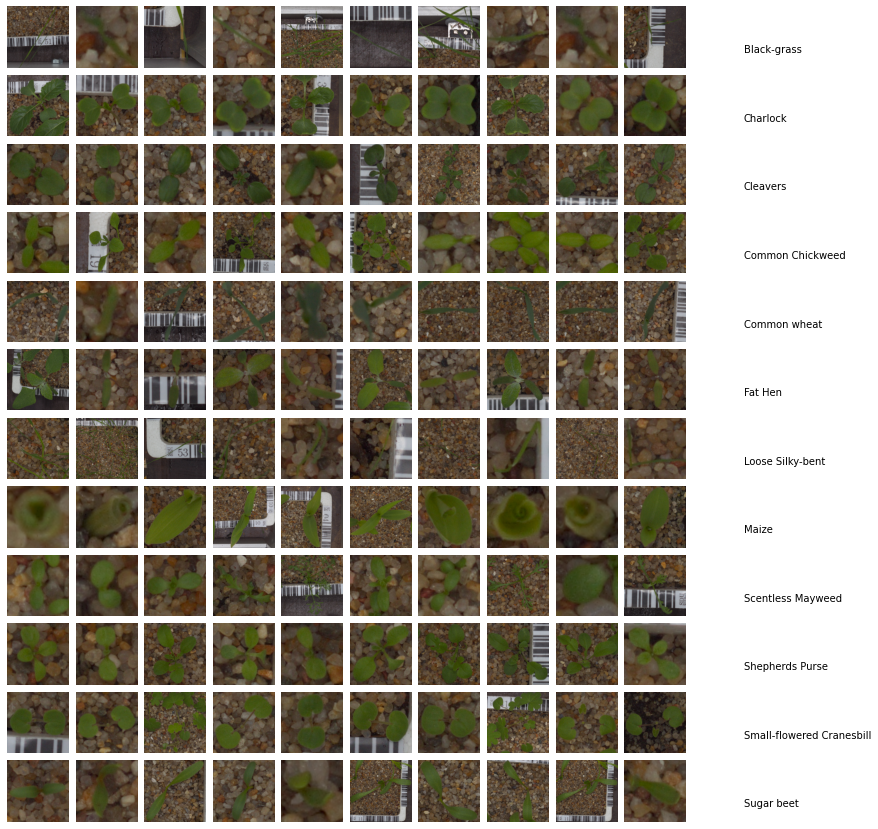

In [ ]:
fig = plt.figure(1, (20, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(12, 10), axes_pad=0.1)

n_img_class = []
counter = 0
for idx, label in enumerate(label_names):
    paths = glob.glob(os.path.join("train", label, "*.png"))
    n_img_class.append([label, len(paths)])
    perm = np.random.choice(len(paths), size=10)

    title = True
    for ii in perm:
        ax = grid[counter]
        if title:
            ax.text(1800, 105, label, verticalalignment="center")
            title = False
        img = cv2.imread(paths[ii])
        img = cv2.resize(img, (150, 150))
        ax.axis("off")
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        counter += 1
        
plt.show()

In [ ]:
img.shape

(150, 150, 3)

**Reading Images**

In this step, we simply store the path to our image dataset into a variable and then we create a function to load folders containing images into arrays so that computers can deal with it.

In [ ]:
#save the path into variable to use it easily next times.
TRAIN_FOLDER= "train"

In [ ]:
from glob import glob
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAIN_FOLDER):
    class_folder_path = os.path.join(TRAIN_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missing value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [ ]:
len(images)

4767

**Resizing images**
Some images captured by a camera and fed to our AI algorithm vary in size, therefore, we should establish a base size for all images fed into our AI algorithms by resizing them.

In [ ]:
# resize image
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in images]

In [ ]:
images[0].shape

(256, 256, 3)

In [ ]:
#see number of images in each label
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (4767, 256, 256, 3)
classes shape:  (4767,)


**Viewing the distribution of number of images in each class**

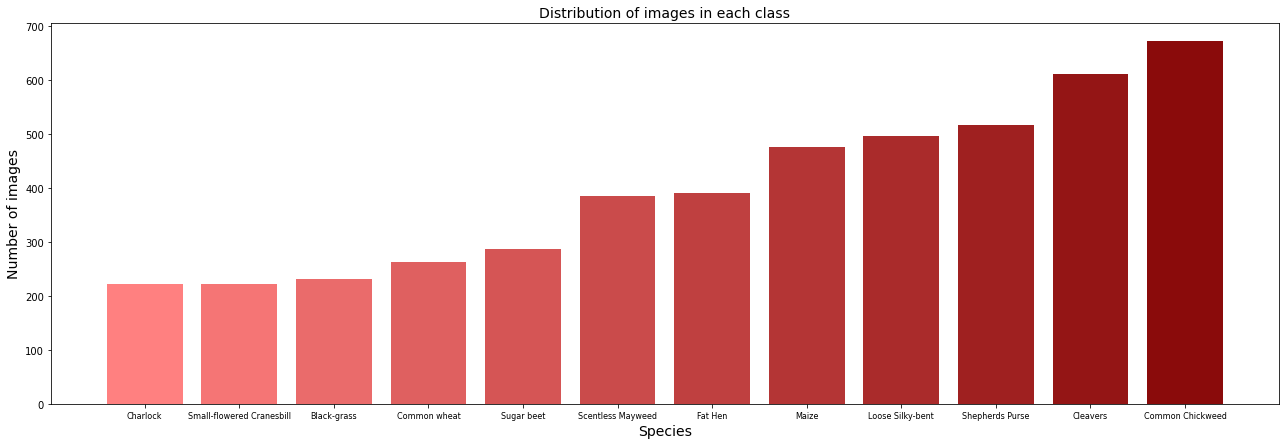

In [ ]:
values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

values.sort()

code=np.arange(0,13,1)
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values, color=color_map(data_normalizer(code)))
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 10)
plt.xlabel("Species", fontsize = 14)
plt.ylabel("Number of images", fontsize = 14)
plt.title("Distribution of images in each class", fontsize=14)
plt.show()

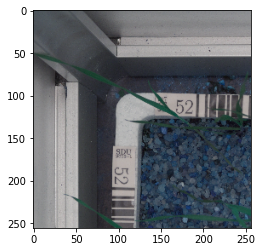

In [ ]:
plt.imshow(images[50])

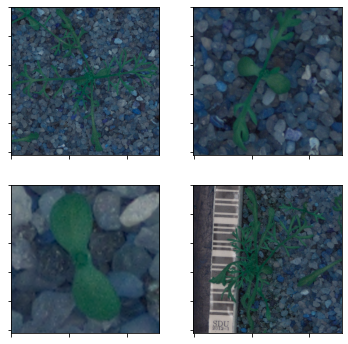

In [ ]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("Scentless Mayweed")

In [ ]:
#!ls "train/Scentless Mayweed" 1300c3cd9.png

img = cv2.imread("train/Scentless Mayweed/1300c3cd9.png")

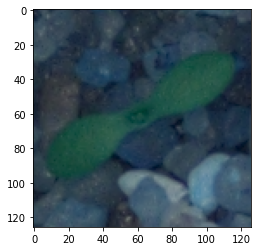

In [ ]:
plt.imshow(img)

# **Image Classification**

Structure of an Image Classification Task

---


1.   Image Preprocessing - The aim of this process is to improve the image data
(features) by suppressing unwanted distortions and enhancement of some important image features so that our Computer Vision models can benefit from this improved data to work on.
2.   Detection of an object - Detection refers to the localization of an object which means the segmentation of the image and identifying the position of the object of interest.
3. Feature extraction and Training- This is a crucial step wherein statistical or deep learning methods are used to identify the most interesting patterns of the image, features that might be unique to a particular class and that will, later on, help the model to differentiate between different classes. This process where the model learns the features from the dataset is called model training.
4. Classification of the object - This step categorizes detected objects into predefined classes by using a suitable classification technique that compares the image patterns with the target patterns.

# *Image Preprocessing*

Pre-processing is a common name for operations with images at the lowest level of abstraction — both input and output are intensity images.

Need for Image-Preprocessing:

---


Computers are able to perform computations on numbers and is unable to interpret images in the way that we do. We have to somehow convert the images to numbers for the computer to understand.
The aim of pre-processing is an improvement of the image data that suppresses unwilling distortions or enhances some image features important for further processing.

**Converting images from RGB to HSV and applying mophological transformations**

In [ ]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

**Applying Segmentation**

In [ ]:
def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

**Applying Sharpening**

In [ ]:
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [ ]:
# Combining all functions

def preprocess(img):
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

for indx, image in enumerate(images):
  try:
    images[indx] = preprocess(image)
      
  except:
    print(indx)
    continue

**Viewing the pre-processed images**

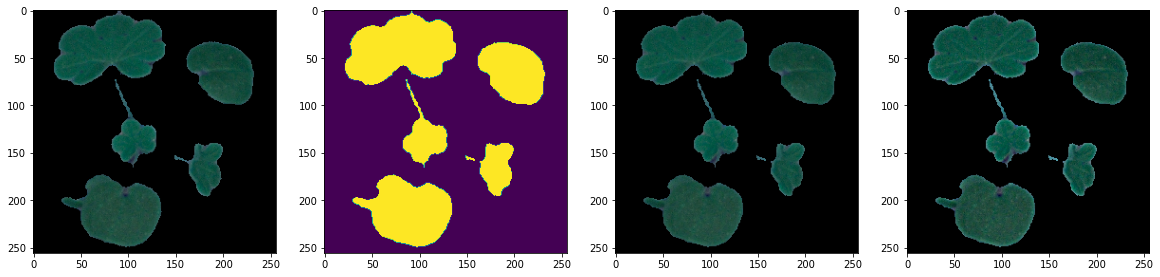

In [ ]:
images = np.array(images)
classes = np.array(classes)
image = images[classes == "Small-flowered Cranesbill"][40]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

In [ ]:
model_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss','Predicted Class'])

In [ ]:
number_of_columns = images[1].shape[0] * images[1].shape[1]
print(number_of_columns)

65536


**Reading the image to predict**

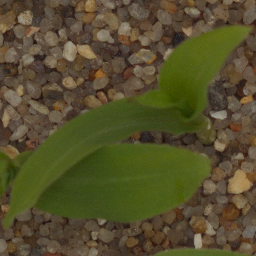

The shape of image to be predicted is:'(578, 578, 3)'
The shape of image to be predicted after expanding the dimensions is:'(1, 256, 256, 3)'


In [ ]:
from google.colab.patches import cv2_imshow

img_pred = cv2.imread('/content/drive/MyDrive/PGP AIML/Artificial Intelligence and Machine Learning/University of Texas/Projects/Computer Vision/Seedling - Prediction/Predict.png')
img_pred_resize = cv2.resize(img_pred,(256,256), interpolation = cv2.INTER_CUBIC)
cv2_imshow(img_pred_resize)
img_predict = np.expand_dims(img_pred_resize, axis=0)
print(f"The shape of image to be predicted is:'{img_pred.shape}'")
print(f"The shape of image to be predicted after expanding the dimensions is:'{img_predict.shape}'")

**Encoding the Target Variable**

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(classes)

num_classes = len(np.unique(y))
num_classes


12

**Splitting data into training and testing set**

training set : 70%

testing set: 30%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

**Creating validation set**

splitting test and validation sets each with 50% of data

In [ ]:
random_seed = 2
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [ ]:
print(f"#### Shapes of Train, Test and Validation sets are: {X_train.shape},{X_test.shape},{X_val.shape}")

#### Shapes of Train, Test and Validation sets are: (3336, 256, 256, 3),(715, 256, 256, 3),(716, 256, 256, 3)


In [ ]:
print(f"#### Shapes of Train, Test and Validation sets of Target are: {y_train.shape},{y_test.shape},{y_val.shape}")

#### Shapes of Train, Test and Validation sets of Target are: (3336,),(715,),(716,)


In [ ]:
# import tensorflow as tf
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
# y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

# *Classification using Supervised Learning Techniques*

1. **Support Vector Machines**

The dataset have over 65536 features for each image and only 3336 images total in train dataset. To use an SVM, our model of choice, the number of features needs to be reduced.

PCA is a way of linearly transforming the data such that most of the information in the data is contained within a smaller number of features called components.

In [ ]:
def flatten(X):
  Xr, Xg, Xb = [],[],[]
  for samples in X:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

In [ ]:
X_train_r, X_train_g, X_train_b = flatten(X_train)
X_test_r, X_test_g, X_test_b = flatten(X_test)
X_val_r, X_val_g, X_val_b = flatten(X_val)

In [ ]:
X_train_r.shape, X_train_g.shape, X_train_b.shape,
X_test_r.shape, X_test_g.shape, X_test_b.shape,
X_val_r.shape, X_val_g.shape, X_val_b.shape

((716, 65536), (716, 65536), (716, 65536))

In [ ]:
n_components = 500
X_train_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_r)
X_train_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_g)
X_train_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_b)

X_test_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_r)
X_test_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_g)
X_test_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_b)

X_val_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_r)
X_val_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_g)
X_val_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_b)

In [ ]:
Xr_train_pca = X_train_pca_r.transform(X_train_r)
Xg_train_pca = X_train_pca_g.transform(X_train_g)
Xb_train_pca = X_train_pca_b.transform(X_train_b)

Xr_test_pca = X_test_pca_r.transform(X_test_r)
Xg_test_pca = X_test_pca_g.transform(X_test_g)
Xb_test_pca = X_test_pca_b.transform(X_test_b)

Xr_val_pca = X_val_pca_r.transform(X_val_r)
Xg_val_pca = X_val_pca_g.transform(X_val_g)
Xb_val_pca = X_val_pca_b.transform(X_val_b)

In [ ]:
X_train_pca_r.explained_variance_ratio_.sum(), X_train_pca_g.explained_variance_ratio_.sum(), X_train_pca_b.explained_variance_ratio_.sum(),
X_test_pca_r.explained_variance_ratio_.sum(), X_test_pca_g.explained_variance_ratio_.sum(), X_test_pca_b.explained_variance_ratio_.sum(),
X_val_pca_r.explained_variance_ratio_.sum(), X_val_pca_g.explained_variance_ratio_.sum(), X_val_pca_b.explained_variance_ratio_.sum()

(0.9575248887793946, 0.9790347564855298, 0.9712513978179084)

In [ ]:
X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)
X_val_pca = np.concatenate([Xr_val_pca,Xg_val_pca,Xb_val_pca], axis=1)

In [ ]:
X_train_pca.shape, y_train.shape,
X_test_pca.shape, y_test.shape,
X_val_pca.shape, y_val.shape

((716, 1500), (716,))

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = SVC()
clf = GridSearchCV(svc, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [ ]:
X_train.shape[0]

3336

In [ ]:
y_train.shape[0]

3336

In [ ]:
svm_score = clf.score(X_val_pca, y_val)

In [ ]:
y_pred = clf.predict(X_test_pca)
svm_accuracy = metrics.accuracy_score(y_test, y_pred)

**Prediction using SVM**

In [ ]:
pred_img = np.squeeze(img_predict, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)

In [ ]:
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

In [ ]:
pred_svm = clf.predict(X_pred_pca)[0]

print(f"The predicted label is:'{pred_svm}'")

The predicted label is:'7'


In [ ]:
model_performance = model_performance.append({'Model':'SVM',
                                              'Accuracy': svm_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_svm                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.352448,NA,7


2. **Random Forest**

In [ ]:
param_grid=[
            {'n_estimators':[100,200],
             'min_samples_leaf':[2,3]}
           ]
rf = RandomForestClassifier()
clf = GridSearchCV(rf, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  1.3min remaining:   20.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
rf_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
rf_accuracy = metrics.accuracy_score(y_test, y_pred)
pred_rf = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_rf}'")

The predicted label is:'1'


In [ ]:
model_performance = model_performance.append({'Model':'RF',
                                              'Accuracy': rf_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_rf                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.352448,NA,7
1,RF,0.457343,NA,1


 **3. Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
param_grid = [
              {'max_leaf_nodes': list(range(2, 100)), 
               'min_samples_split': [2, 3, 4]}
              ]
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 

In [ ]:
dt_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
dt_accuracy = metrics.accuracy_score(y_test, y_pred)
pred_dt = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_dt}'")

The predicted label is:'1'


In [ ]:
model_performance = model_performance.append({'Model':'DT',
                                              'Accuracy': dt_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_dt                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.352448,NA,7
1,RF,0.457343,NA,1
2,DT,0.437762,NA,1


# *Classification using Artificial Neural Network (ANN)*

In [ ]:
import itertools

import tensorflow
from tensorflow.python.keras.layers import Dense, Dropout, InputLayer, BatchNormalization, Flatten
from tensorflow.python.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [ ]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(classes)

In [ ]:
y2[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)

In [ ]:
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [ ]:
X_train.shape,y_train.shape

((3336, 256, 256, 3), (3336, 12))

In [ ]:
num_classes = len(np.unique(y_train))
num_classes

2

In [ ]:
def ann_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  # batch_size = None

  model = Sequential()

  model.add(InputLayer(input_shape=(height, width, num_channels)))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))
  opt = tensorflow.keras.optimizers.Adam(lr=0.000001)
  model.compile(optimizer = opt, loss = loss, metrics = metrics)

  model.summary()
  return model

In [ ]:
ann = ann_model(256,256,3,12)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 196608)            0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 196608)            786432    
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              201327616 
_________________________________________________________________
dropout_21 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_19 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)              

In [ ]:
history = ann.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val),
                  batch_size = batch_size)

Epoch 1/50
88/88 [==============================] - 5s 39ms/step - loss: 3.0252 - accuracy: 0.1173 - val_loss: 2.2924 - val_accuracy: 0.2723
Epoch 2/50
88/88 [==============================] - 3s 37ms/step - loss: 2.2007 - accuracy: 0.2922 - val_loss: 1.8298 - val_accuracy: 0.4120
Epoch 3/50
88/88 [==============================] - 3s 37ms/step - loss: 1.8693 - accuracy: 0.3833 - val_loss: 1.6600 - val_accuracy: 0.4693
Epoch 4/50
88/88 [==============================] - 3s 36ms/step - loss: 1.6250 - accuracy: 0.4591 - val_loss: 1.5585 - val_accuracy: 0.4972
Epoch 5/50
88/88 [==============================] - 3s 36ms/step - loss: 1.4793 - accuracy: 0.4918 - val_loss: 1.4995 - val_accuracy: 0.5279
Epoch 6/50
88/88 [==============================] - 3s 37ms/step - loss: 1.3931 - accuracy: 0.5291 - val_loss: 1.4462 - val_accuracy: 0.5475
Epoch 7/50
88/88 [==============================] - 3s 36ms/step - loss: 1.3348 - accuracy: 0.5553 - val_loss: 1.4064 - val_accuracy: 0.5545
Epoch 8/50
88

In [ ]:
ann_loss, ann_accuracy = ann.evaluate(X_test, y_test, verbose=1)
print('Test loss:', ann_loss)
print('Test accuracy:', ann_accuracy)

23/23 [==============================] - 0s 12ms/step - loss: 1.0452 - accuracy: 0.6476
Test loss: 1.0452253818511963
Test accuracy: 0.6475524306297302


**Model Evaluation**

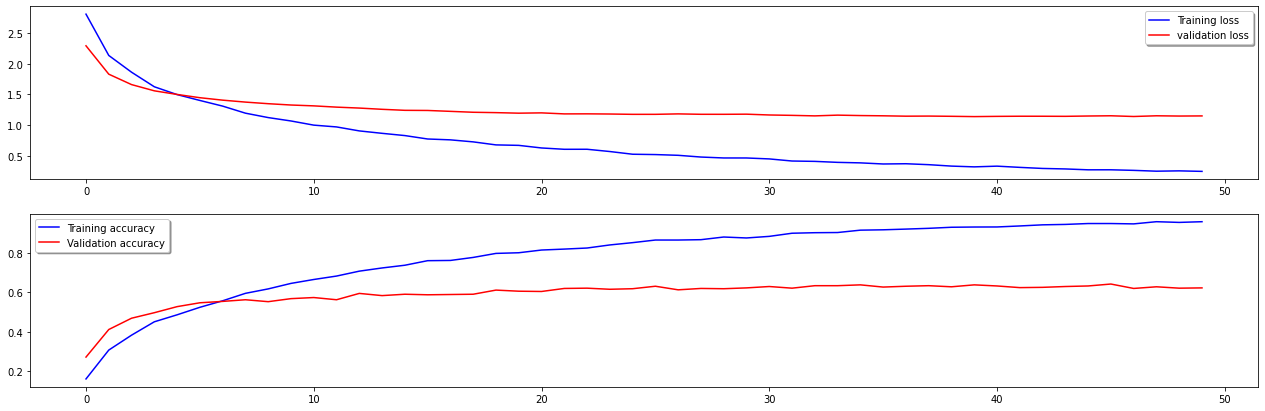

In [ ]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

**Confusion Matrix**

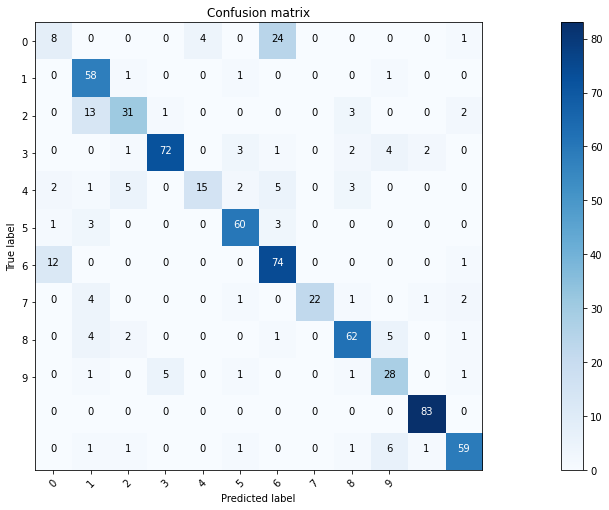

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [ ]:
ann_predict = np.argmax(ann.predict(img_predict))

In [ ]:
print('The predicted flower is with label:', ann_predict)

The predicted flower is with label: 1


In [ ]:
model_performance = model_performance.append({'Model':'ANN',
                                              'Accuracy': ann_accuracy,
                                              'Loss': ann_loss,
                                              'Predicted Class': ann_predict                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,ANN,0.647552,1.045225,1


# *Classification using Convolution Neural Network (CNN)*

In [ ]:
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [ ]:
cnn = cnn_model(256,256,3,12)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 64)       

In [ ]:
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val),
                  batch_size = batch_size)

Epoch 1/50
88/88 [==============================] - 13s 135ms/step - loss: 4.7456 - accuracy: 0.1238 - val_loss: 2.4016 - val_accuracy: 0.1215
Epoch 2/50
88/88 [==============================] - 12s 132ms/step - loss: 2.4493 - accuracy: 0.1685 - val_loss: 2.1961 - val_accuracy: 0.2793
Epoch 3/50
88/88 [==============================] - 12s 132ms/step - loss: 2.0866 - accuracy: 0.2876 - val_loss: 2.1546 - val_accuracy: 0.2500
Epoch 4/50
88/88 [==============================] - 12s 132ms/step - loss: 1.9102 - accuracy: 0.3451 - val_loss: 1.9525 - val_accuracy: 0.3911
Epoch 5/50
88/88 [==============================] - 12s 132ms/step - loss: 1.6796 - accuracy: 0.4161 - val_loss: 1.6663 - val_accuracy: 0.4874
Epoch 6/50
88/88 [==============================] - 12s 133ms/step - loss: 1.6024 - accuracy: 0.4412 - val_loss: 1.5024 - val_accuracy: 0.5084
Epoch 7/50
88/88 [==============================] - 12s 132ms/step - loss: 1.3339 - accuracy: 0.5267 - val_loss: 1.4560 - val_accuracy: 0.5601

In [ ]:
cnn_loss, cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss)
print('Test accuracy:', cnn_accuracy)

23/23 [==============================] - 1s 27ms/step - loss: 0.7394 - accuracy: 0.7580
Test loss: 0.7393622994422913
Test accuracy: 0.7580419778823853


In [ ]:
cnn_predict = np.argmax(cnn.predict(img_predict))

In [ ]:
model_performance = model_performance.append({'Model':'CNN',
                                              'Accuracy': cnn_accuracy,
                                              'Loss': cnn_loss,
                                              'Predicted Class': cnn_predict                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,ANN,0.647552,1.045225,1
1,CNN,0.758042,0.739362,7


**Data Augmentation**

In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 30
batch_size = 38

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
# X_train, X_test, y_train, y_test
history = cnn.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
87/87 - 45s - loss: 0.6598 - accuracy: 0.7884 - val_loss: 0.7056 - val_accuracy: 0.7654
Epoch 2/30
87/87 - 44s - loss: 0.5951 - accuracy: 0.8008 - val_loss: 0.7229 - val_accuracy: 0.7779
Epoch 3/30
87/87 - 44s - loss: 0.6166 - accuracy: 0.7893 - val_loss: 0.6678 - val_accuracy: 0.7919
Epoch 4/30
87/87 - 43s - loss: 0.5963 - accuracy: 0.8029 - val_loss: 0.5951 - val_accuracy: 0.7975
Epoch 5/30
87/87 - 44s - loss: 0.5747 - accuracy: 0.8023 - val_loss: 0.7060 - val_accuracy: 0.7765
Epoch 6/30
87/87 - 44s - loss: 0.5873 - accuracy: 0.8026 - val_loss: 0.8921 - val_accuracy: 0.7067
Epoch 7/30
87/87 - 44s - loss: 0.5783 - accuracy: 0.8062 - val_loss: 0.7342 - val_accuracy: 0.7640
Epoch 8/30
87/87 - 46s - loss: 0.5785 - accuracy: 0.8220 - val_loss: 0.8069 - val_accuracy: 0.7598
Epoch 9/30
87/87 - 46s - loss: 0.5921 - accuracy: 0.8017 - val_loss: 0.5347 - val_accuracy: 0.8017
Epoch 10/30
87/87 - 44s - loss: 0.5613 - accuracy: 0.8032 - val_loss: 0.7470 - val_accuracy: 0.7472
Epoch 11/

In [ ]:
cnn_loss_aug, cnn_accuracy_aug = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss_aug)
print('Test accuracy:', cnn_accuracy_aug)

23/23 [==============================] - 1s 27ms/step - loss: 0.5761 - accuracy: 0.8098
Test loss: 0.5760908126831055
Test accuracy: 0.8097901940345764


**Model Evaluation**

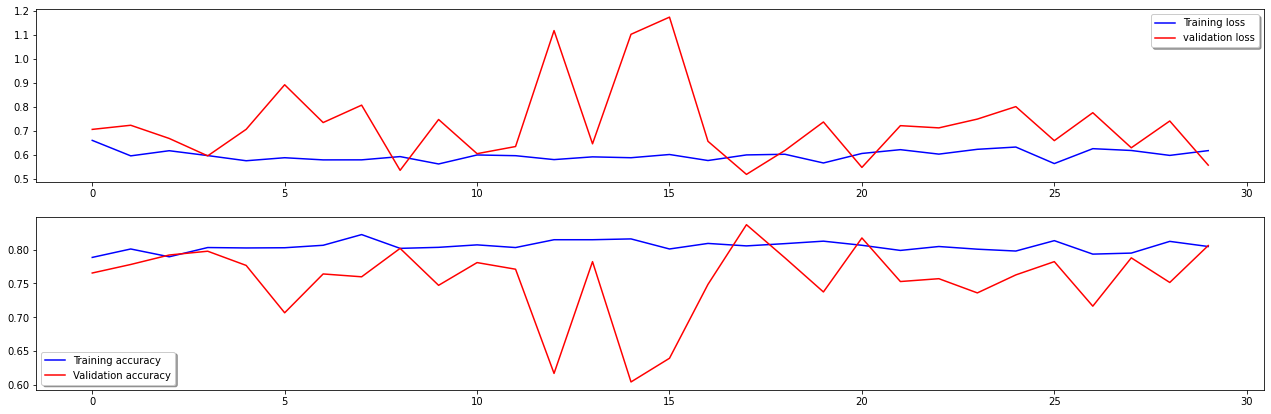

In [ ]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

**Confusion Matrix**

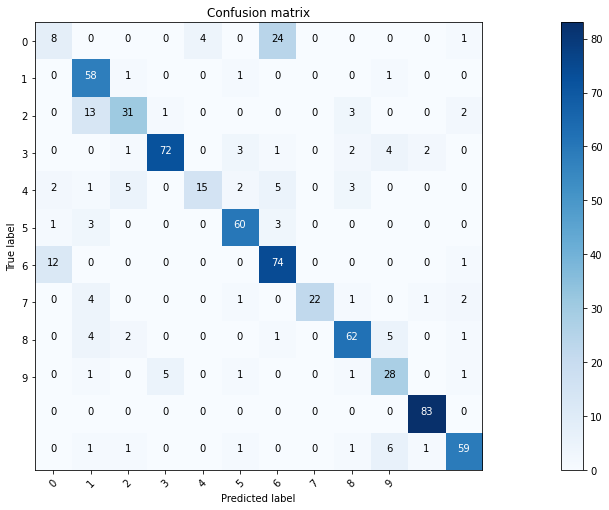

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [ ]:
cnn_predict_aug = np.argmax(cnn.predict(img_predict))

In [ ]:
print('The predicted flower is with label:', cnn_predict)

The predicted flower is with label: 7


In [ ]:
model_performance = model_performance.append({'Model':'CNN with Data Augmentaion',
                                              'Accuracy': cnn_accuracy_aug,
                                              'Loss': cnn_loss_aug,
                                              'Predicted Class': cnn_predict_aug                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,ANN,0.647552,1.045225,1
1,CNN,0.758042,0.739362,7
2,CNN with Data Augmentaion,0.809790,0.576091,1


**Saving the best model**

In [ ]:
model.save("CNN_PlantSeedling_ImageClassification.h5")